In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scanpy as sc

from molecular_cross_validation.mcv_sweep import GridSearchMCV
from molecular_cross_validation.util import poisson_fit

In [2]:
import molecular_cross_validation.util as ut
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import mean_squared_error

In [3]:
import sys
sys.path.append("../cNMF")
from cnmf import load_df_from_npz

In [4]:
def pca_sweep(umis, data_split = 0.9, n_trials = 1, true_counts = 5e5, max_components=20, spacing=1, seed=42):

    seed = sum(map(ord, f"biohub_{seed}"))
    random_state = np.random.RandomState(seed)

    k_range = np.arange(1, max_components + 1, spacing)

    mcv_loss = np.empty((n_trials, k_range.shape[0]), dtype=float)

    data_split, data_split_complement, overlap = ut.overlap_correction(
        data_split, umis.sum(1, keepdims=True) / true_counts
    )

    # run n_trials for self-supervised sweep
    for i in range(n_trials):
        umis_X, umis_Y = ut.split_molecules(umis, data_split, overlap, random_state)

        umis_X = np.sqrt(umis_X)
        umis_Y = np.sqrt(umis_Y)

        U, S, V = randomized_svd(umis_X, n_components=max_components)
        US = U.dot(np.diag(S))

        for j, k in enumerate(k_range):
            pca_X = US[:, :k].dot(V[:k, :])
            conv_exp = ut.convert_exp_sqrt(pca_X, data_split, data_split_complement)

            mcv_loss[i, j] = mean_squared_error(umis_Y, conv_exp)
    
    return k_range, mcv_loss

In [5]:
umis = load_df_from_npz("data/Part1_Simulations/deloc_1.00/Seed_12045/counts.npz").values

In [6]:
poisson_p_val = poisson_fit(umis)

In [7]:
umis = umis[:, poisson_p_val < 0.01]

In [8]:
k_range, mcv_loss = pca_sweep(umis, max_components=120, spacing=2)

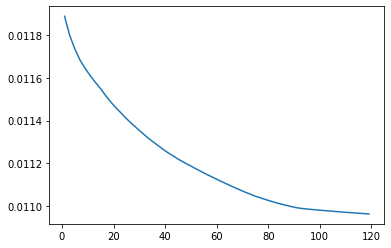

In [9]:
plt.plot(k_range, mcv_loss[0])

In [10]:
k_range[np.argmin(mcv_loss[0])]

119